In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Check if GPU is available
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [21]:
df_all = pd.read_csv('eua_price_data_High_Low.csv', thousands=',') 
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all = df_all.sort_values(by = 'Date', ascending=True).reset_index(drop = True)
df_all = df_all[(df_all['Date'] > pd.to_datetime('2020-11-24'))].reset_index(drop=True)

# Preprocessing & train/test data split

In [22]:
from script.curate_training_test_data import  curate_training_test_data_many

predictors_lst =['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean', 'High_price', 'Low_price']
test_date = '2024-07-23' 
sequence_length = 28
checkpoint_path = "best_mutistep_nn_model.pth"

last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
                                            df_all, 
                                            flatten=True,
                                            sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
                                            sequence_length_out=28,    # 입력 시퀀스 길이 (30일)
                                            test_date=test_date,
                                            predictors_lst=predictors_lst,
                                            dtype = 'float32',
                                            is_test_split = True,
                                        )

# Convert to PyTorch tensor
X_train_tensor, y_train_tensor = torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device)
X_test_tensor, y_test_tensor = torch.from_numpy(X_test).to(device), torch.from_numpy(y_test).to(device)

# Train the Model

In [23]:
from script.generate_DenseLayer_torch import generate_nn_multi_step, train_NN
model = generate_nn_multi_step(X_train_tensor, y_train_tensor)

if os.path.isfile('best_mutistep_nn_model.pth'):
    model.load_state_dict(torch.load('best_mutistep_nn_model.pth'))
else:
    history = train_NN(model, 
                       checkpoint_path, 
                        X_train_tensor, y_train_tensor, 
                        X_test_tensor, y_test_tensor,
                        patience=5000,
                        batch_size=129, # batch should not be 128!! 
                        epochs=5000, verbose=100)

# Visualize - Loss cureve

In [24]:
# ## visualize loss curve plot
# plt.figure(figsize=(10, 5))
# plt.plot(history['train_loss'], label='Training Loss')
# plt.plot(history['val_loss'], label='Validation Loss')
# a = np.array(history['val_loss'])
# plt.axvline(np.where(a==a.min())[0][0], color = 'red')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Over Epochs')
# # plt.ylim([0,5])
# plt.yscale('log')
# plt.legend()
# plt.grid('on')
# plt.show()

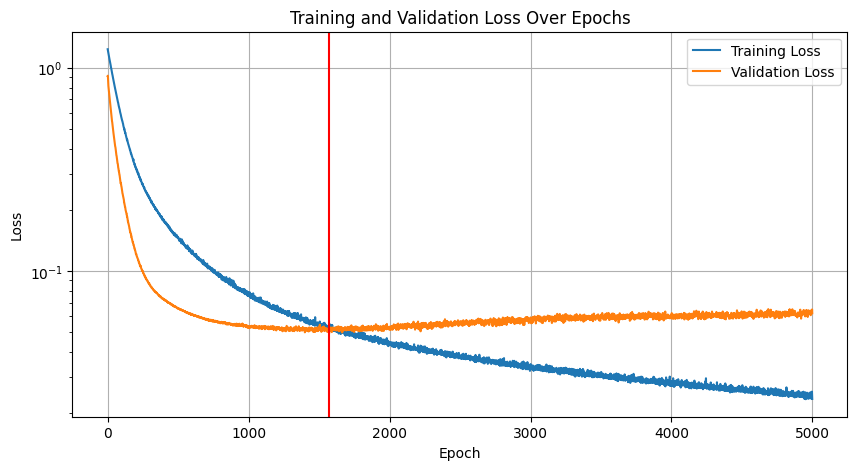

# Assess train and validation prediction performance

In [25]:
# prediction for train/validation data
model.to('cpu') # model.to('cuda')  

model.eval()
y_train_pred = model(X_train_tensor.cpu()).detach().numpy()
y_test_pred = model(X_test_tensor.cpu()).detach().numpy()

y_test_preds = []
model.train()
for i in range(10):
    y_test_preds.append(model(X_test_tensor.cpu()).detach().numpy())

In [26]:
from script.post_processing import inverse_scaler_of_all_var
y_train_pred = inverse_scaler_of_all_var(y_train_pred, scaler).reshape(-1,sequence_length,len(predictors_lst))
y_test_pred  = inverse_scaler_of_all_var(y_test_pred, scaler).reshape(-1,sequence_length,len(predictors_lst))
y_test_preds = [i.reshape(-1,sequence_length,len(predictors_lst)) for i in inverse_scaler_of_all_var(y_test_preds, scaler)]
y_train_true = inverse_scaler_of_all_var(y_train, scaler).reshape(-1,sequence_length,len(predictors_lst))
y_test_true  = inverse_scaler_of_all_var(y_test, scaler).reshape(-1,sequence_length,len(predictors_lst))

In [27]:
# define start of train date and valid/train split date
train_start_date =  df_all['Date'][0] + pd.to_timedelta(28, unit = 'day')
train_test_split_date = pd.to_datetime(test_date)

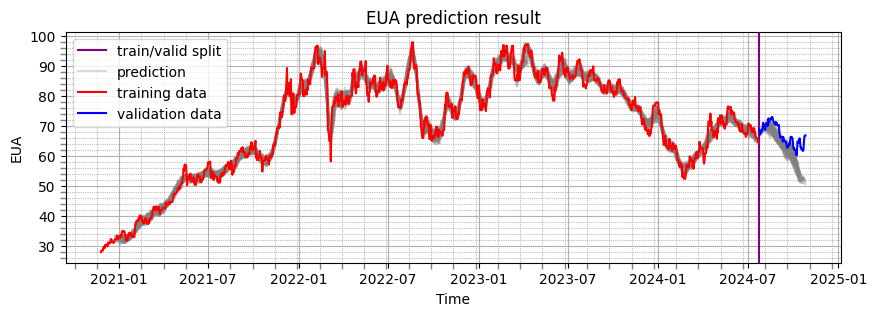

In [28]:
# visuals of train/validation data prediction (single prediction)
from script.post_processing import visual_train_n_valid_data_performance
visual_train_n_valid_data_performance(y_train_pred,y_test_pred, 
                                      train_start_date, train_test_split_date, df_all,
                                      figsize = (10,3),
                                      decoration = {'xlabel': 'Time', 
                                                    'ylabel':'EUA', 
                                                    'title':'EUA prediction result',
                                                    'grid':'on'})


In [30]:
from script.save_permformance import save_perform
model_name ='nn'
# save_perform(model_name, y_train_true, y_train_pred, y_test_true, y_test_pred)

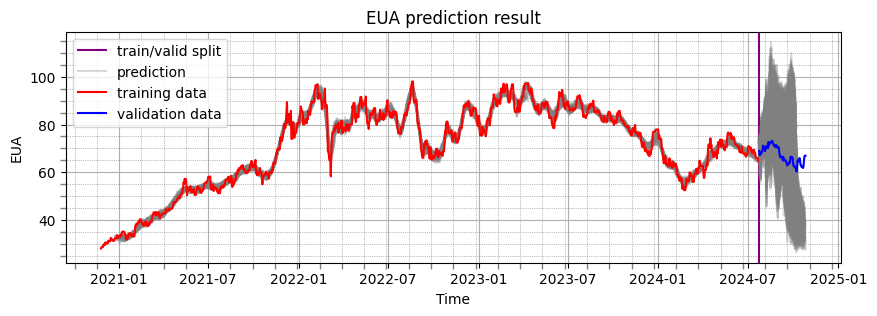

In [32]:
# visual ensemble of predictions
visual_train_n_valid_data_performance(y_train_pred,y_test_preds, train_start_date, train_test_split_date, df_all,
                                      figsize = (10,3),
                                      index_of_data = 0,
                                      name_of_data = 'EUA',
                                      decoration = {'xlabel': 'Time', 
                                                    'ylabel':'EUA', 
                                                    'title':'EUA prediction result',
                                                    'grid':'on'})

In [129]:
for i, name in enumerate(['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean',]):
    visual_train_n_valid_data_performance(y_train_pred,y_test_preds, train_start_date, train_test_split_date, df_all,
                                        figsize = (10,3),
                                        index_of_data = i,
                                        name_of_data = name,
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':name, 
                                                        'title':f'{name} prediction result',
                                                        'grid':'on'})

# Recursive future prediction (test)

In [34]:
# 2. add recursive scheme
from script.post_processing import resursive_furture_prediction_with_dropout_in_cpu
model.train()
future_price_ensemble, future_time = resursive_furture_prediction_with_dropout_in_cpu(model, 
                                                                                      X_test_tensor[-1],
                                                                                        train_test_split_date = df_all['Date'].max(),
                                                                                        num_of_ensemble = 100,
                                                                                        scaler = scaler,
                                                                                        df_all = df_all,
                                                                                        flatten  = True)

In [131]:
from script.post_processing import visual_recursive_future_prediction_plotly
visual_recursive_future_prediction_plotly(future_time, future_price_ensemble,
                                       train_test_split_date,
                                       df_all,
                                          
                                          index_of_data= 0, # 0 is EUA price
                                          name_of_data = 'EUA',
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':'EUA', 
                                                        'title':'EUA prediction result',
                                                        'grid':'on'})
                                          

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



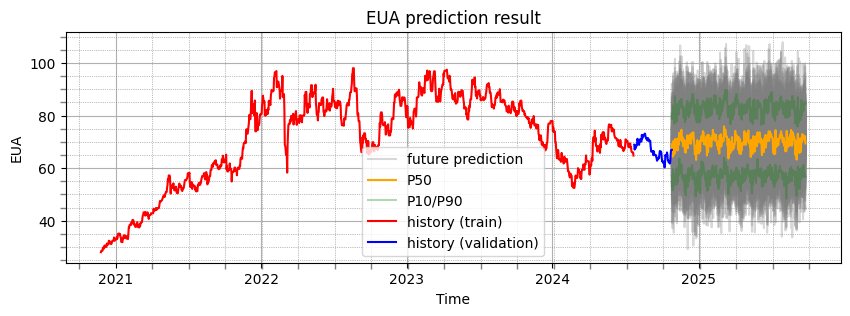

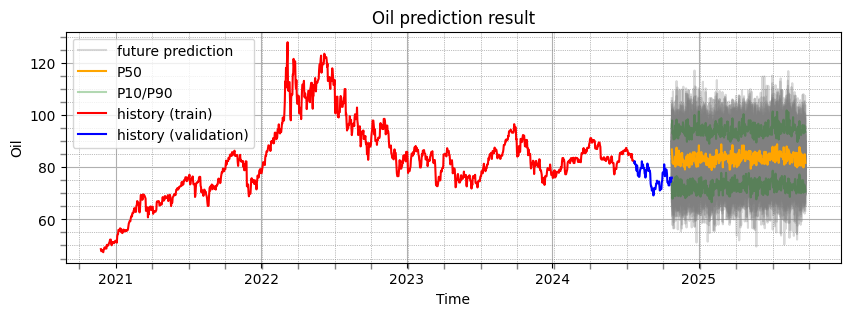

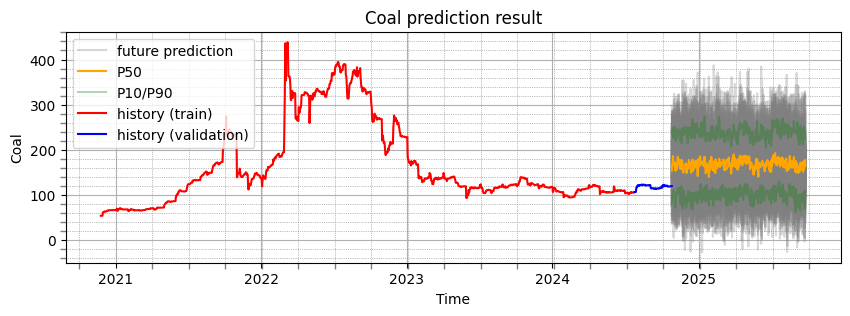

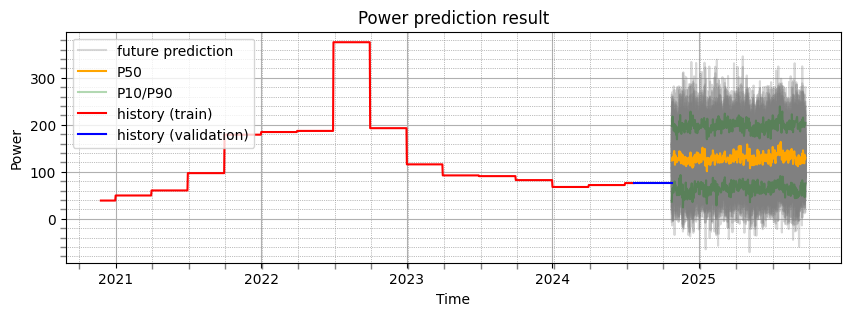

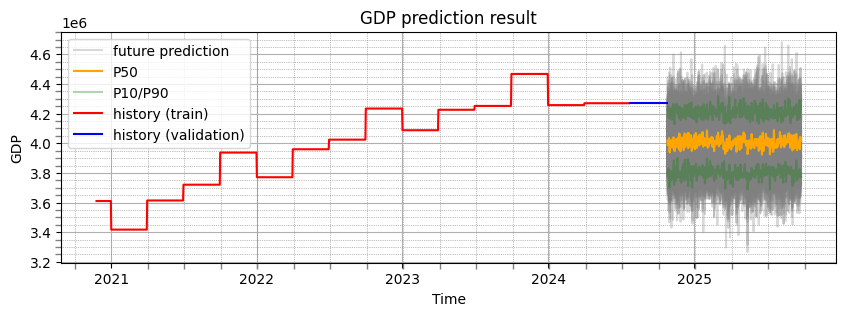

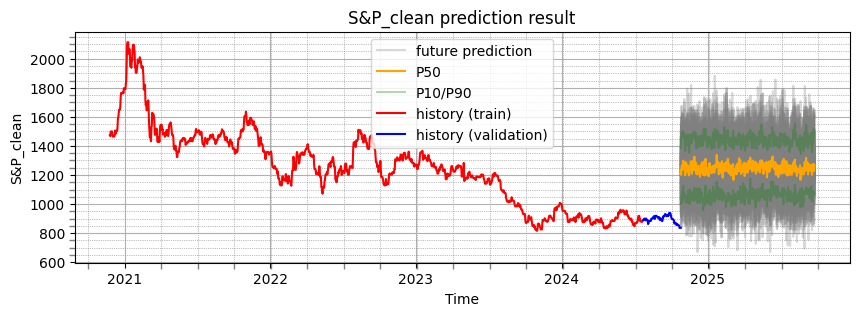

In [35]:
from script.post_processing import visual_recursive_future_prediction
for i, name in enumerate(['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean',]):
    visual_recursive_future_prediction(future_time, future_price_ensemble,
                                       train_test_split_date,
                                       df_all,
                                          figsize = (10,3),
                                          index_of_data= i, # 0 is EUA price
                                          name_of_data = name,
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':name, 
                                                        'title':f'{name} prediction result',
                                                        'grid':'on'})
                                          